In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.gridspec as gridspec
from numpy import random
import scipy.stats as scipy

from IPython.display import display

from sklearn.metrics import accuracy_score

with sqlite3.connect('database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    tempmatch = pd.read_sql_query("SELECT * from Match", con)
    matches3 = matches2 = matches

Initially I am performing Exploratory Data Analysis on the dataset I got from the Kaggle website.

This dataset was in sqlite format and has tables of Country, League, Match, Player, Player Attributes, Team ,Team Attributes and sequences. It has information of more than 25000 matches, 10000 players, 11 European Countries with their lead championship from 2008 to 2016, Players and Teams attributes sourced from EA Sports' FIFA video game series, betting odds from up to 10 providers

I am only going to use the information from country, match, league and team for the EDA. This are the information which would be useful to understand the game.

In [2]:
matches.tail()
#matches.describe()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [4]:
leagues

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [5]:
teams


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
...,...,...,...,...,...
294,49479,10190,898.0,FC St. Gallen,GAL
295,49837,10191,1715.0,FC Thun,THU
296,50201,9777,324.0,Servette FC,SER
297,50204,7730,1862.0,FC Lausanne-Sports,LAU


Selecting the countries of interest

First we will to select the countries of interest for our analysis. I am selecting England, Germany and Spain as these are the most popular and most watched leagues in football. These leagues are the most competitive league and it would give better understanding of the game.

In [6]:
main_countries = ['England','Germany','Spain']
countries = countries[countries.name.isin(main_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
seasons = matches.season.unique()
leagues

,id,name,country_id,name_y
0,1729,England,1729,England Premier League
1,7809,Germany,7809,Germany 1. Bundesliga
2,21518,Spain,21518,Spain LIGA BBVA


Merge the leagues with corresponding matches

In [7]:
req_matches = matches[matches.league_id.isin(leagues['id'])]
req_matches = req_matches[['id','league_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','season']]
req_matches["total_goals"] = req_matches['home_team_goal'] + req_matches['away_team_goal']
req_matches.dropna(inplace=True)
req_matches.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals
1728,1729,1729,10260,10261,1,1,2008/2009,2
1729,1730,1729,9825,8659,1,0,2008/2009,1
1730,1731,1729,8472,8650,0,1,2008/2009,1
1731,1732,1729,8654,8528,2,1,2008/2009,3
1732,1733,1729,10252,8456,4,2,2008/2009,6


Adding results of the match

As these dataset did not contain the result of the match we would add the results by comparing the home team goal and away team goal for that match. If the home team has more goals than the away team then the home team won the match and if not then the away team won the match. If both the goals are equal matche ended in draw. I am giving win as 1, draw as 0 and loss as -1 and then appended it to the table.


In [8]:
def res(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 1
    else:
        val = -1
    return val

req_matches["result"] = req_matches.apply(res,axis = 1)
req_matches.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result
1728,1729,1729,10260,10261,1,1,2008/2009,2,0
1729,1730,1729,9825,8659,1,0,2008/2009,1,1
1730,1731,1729,8472,8650,0,1,2008/2009,1,-1
1731,1732,1729,8654,8528,2,1,2008/2009,3,1
1732,1733,1729,10252,8456,4,2,2008/2009,6,1


Separating the leagues

The matches need to be separated and grouped by their leagues. A new dataframe for storing the separated leagues is created.

In [9]:
new_matches = pd.merge(req_matches,leagues,left_on='league_id', right_on='id')
new_matches = new_matches.drop(['id_x','id_y','country_id'],axis = 1)
english = new_matches[new_matches.name == "England"]
spanish = new_matches[new_matches.name == "Spain"]
german = new_matches[new_matches.name == "Germany"]

display(english.head())
display(german.head())
display(spanish.tail())

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League
1,1729,9825,8659,1,0,2008/2009,1,1,England,England Premier League
2,1729,8472,8650,0,1,2008/2009,1,-1,England,England Premier League
3,1729,8654,8528,2,1,2008/2009,3,1,England,England Premier League
4,1729,10252,8456,4,2,2008/2009,6,1,England,England Premier League


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
3040,7809,9823,9790,2,2,2008/2009,4,0,Germany,Germany 1. Bundesliga
3041,7809,8178,9789,2,3,2008/2009,5,-1,Germany,Germany 1. Bundesliga
3042,7809,10189,9904,3,0,2008/2009,3,1,Germany,Germany 1. Bundesliga
3043,7809,8721,8722,2,1,2008/2009,3,1,Germany,Germany 1. Bundesliga
3044,7809,9810,8177,0,2,2008/2009,2,-1,Germany,Germany 1. Bundesliga


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
8523,21518,9906,10267,2,1,2015/2016,3,1,Spain,Spain LIGA BBVA
8524,21518,9864,9783,2,0,2015/2016,2,1,Spain,Spain LIGA BBVA
8525,21518,8315,9869,3,0,2015/2016,3,1,Spain,Spain LIGA BBVA
8526,21518,7878,8603,1,1,2015/2016,2,0,Spain,Spain LIGA BBVA
8527,21518,8370,8558,3,0,2015/2016,3,1,Spain,Spain LIGA BBVA


Grouping and dividing by seasons

Then dividing them by their seasons and storing them into new dataframe.

In [10]:
e = english.groupby('season')
s = spanish.groupby('season')
g = german.groupby('season')
seasons
display(e.head(2))
display(s.tail(2))
display(g.tail(2))

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League
1,1729,9825,8659,1,0,2008/2009,1,1,England,England Premier League
380,1729,10260,8658,1,0,2009/2010,1,1,England,England Premier League
381,1729,8586,8650,2,1,2009/2010,3,1,England,England Premier League
760,1729,10252,8654,3,0,2010/2011,3,1,England,England Premier League
761,1729,8655,8668,1,0,2010/2011,1,1,England,England Premier League
1140,1729,8655,8602,1,2,2011/2012,3,-1,England,England Premier League
1141,1729,9879,10252,0,0,2011/2012,0,0,England,England Premier League
1520,1729,9825,8472,0,0,2012/2013,0,0,England,England Premier League
1521,1729,8668,10260,1,0,2012/2013,1,1,England,England Premier League


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
5866,21518,9906,8661,2,0,2008/2009,2,1,Spain,Spain LIGA BBVA
5867,21518,10267,8696,2,4,2008/2009,6,-1,Spain,Spain LIGA BBVA
6246,21518,8394,9865,2,1,2009/2010,3,1,Spain,Spain LIGA BBVA
6247,21518,9864,10267,0,1,2009/2010,1,-1,Spain,Spain LIGA BBVA
6626,21518,9783,8558,3,0,2010/2011,3,1,Spain,Spain LIGA BBVA
6627,21518,8661,8581,2,1,2010/2011,3,1,Spain,Spain LIGA BBVA
7006,21518,8603,8370,0,2,2011/2012,2,-1,Spain,Spain LIGA BBVA
7007,21518,9869,7878,2,0,2011/2012,2,1,Spain,Spain LIGA BBVA
7386,21518,9910,9783,1,1,2012/2013,2,0,Spain,Spain LIGA BBVA
7387,21518,8370,8634,0,5,2012/2013,5,-1,Spain,Spain LIGA BBVA


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
3344,7809,9788,8295,1,0,2008/2009,1,1,Germany,Germany 1. Bundesliga
3345,7809,8226,9790,3,0,2008/2009,3,1,Germany,Germany 1. Bundesliga
3650,7809,8722,9905,1,0,2009/2010,1,1,Germany,Germany 1. Bundesliga
3651,7809,8165,8177,3,0,2009/2010,3,1,Germany,Germany 1. Bundesliga
3956,7809,9904,8722,2,1,2010/2011,3,1,Germany,Germany 1. Bundesliga
3957,7809,8165,8721,2,1,2010/2011,3,1,Germany,Germany 1. Bundesliga
4262,7809,8721,8165,2,1,2011/2012,3,1,Germany,Germany 1. Bundesliga
4263,7809,9788,8178,2,2,2011/2012,4,0,Germany,Germany 1. Bundesliga
4568,7809,8357,8697,1,1,2012/2013,2,0,Germany,Germany 1. Bundesliga
4569,7809,8194,8721,1,4,2012/2013,5,-1,Germany,Germany 1. Bundesliga


Plotting total goals scored each season

We plot the total number of goals scored by all team in each season. We plot this on pyplot.

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

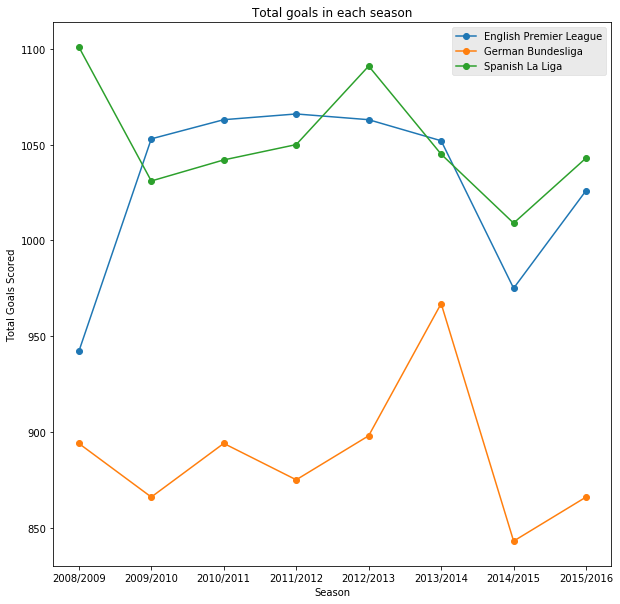

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.title("Total goals in each season")
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.ylabel("Total Goals Scored")
num_seasons = range(len(seasons))

plt.plot(num_seasons,e.total_goals.sum().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,g.total_goals.sum().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,s.total_goals.sum().values,label = "Spanish La Liga", marker = 'o')
plt.legend()
seasons

We can see that the Spanish teams overall score more than the teams in Premier League and in Bundesliga. But the total goals in Bundesliga is low due to the fact that only 18 teams compete in the league. So each team in Bundesliga plays only 34 matches in a season whereas each team in premier league plays 38 matches. So the total games played in Premier League and La Liga is 380 whereas total games played in Bundesliga is 306.

We calculate average goals scored in each game


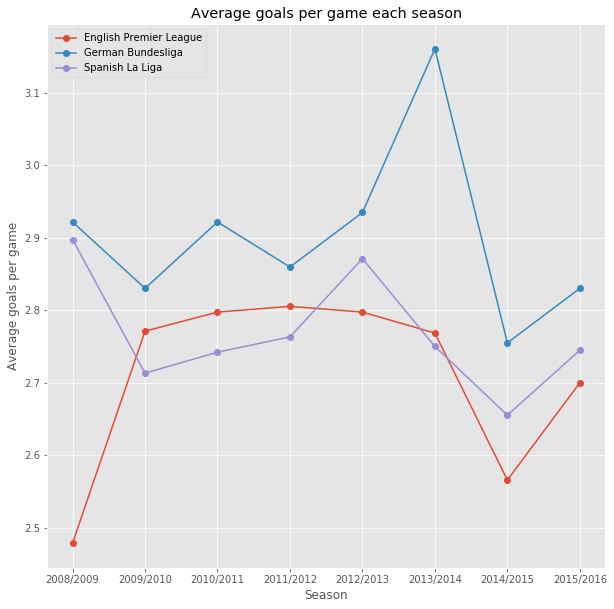

In [12]:
#Plotting average goals scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.title("Average goals per game each season")
plt.ylabel("Average goals per game")

plt.plot(num_seasons,e.total_goals.mean().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,g.total_goals.mean().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,s.total_goals.mean().values,label = "Spanish La Liga", marker = 'o')
plt.legend(loc = 2)


The Bundesliga teams score way more on average in each game that the teams in other leagues. In the 2013/2014 season, Bundesliga teams scored more than 3 goals each game on an average (967 goals in 306 matches - 3.16 per match).

In [13]:
average_goals_english = english.total_goals.mean()
average_goals_spanish = spanish.total_goals.mean()
average_goals_german = german.total_goals.mean()
#print("{:.2}".format(average_goals_english))
#print("{:.2}".format(average_goals_spanish))
#print("{:.2}".format(average_goals_german))

Average goals in the English Premier League is 2.7

Average goals in the Spanish La Liga is 2.8

Average goals in the Germany BundesLiga is 2.9

Top Goal Scoring Team at Home

To see which team scores the most goal when playing on home turf.

In [14]:
#Merging Home team and matches

matches_h_teams = pd.merge(new_matches,teams,left_on='home_team_api_id', right_on='team_api_id')
matches_h_teams = matches_h_teams.drop(['id','team_api_id','team_fifa_api_id'],axis = 1)
matches_h_teams = matches_h_teams.rename(columns={'team_long_name':'home_team_long_name','name_y':'league_name','name':'country_name'})
matches_h_teams.head()

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,country_name,league_name,home_team_long_name,team_short_name
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League,Manchester United,MUN
1,1729,10260,8654,2,0,2008/2009,2,1,England,England Premier League,Manchester United,MUN
2,1729,10260,8667,4,3,2008/2009,7,1,England,England Premier League,Manchester United,MUN
3,1729,10260,10194,5,0,2008/2009,5,1,England,England Premier League,Manchester United,MUN
4,1729,10260,8472,1,0,2008/2009,1,1,England,England Premier League,Manchester United,MUN


Text(0.5, 0, 'Team name')

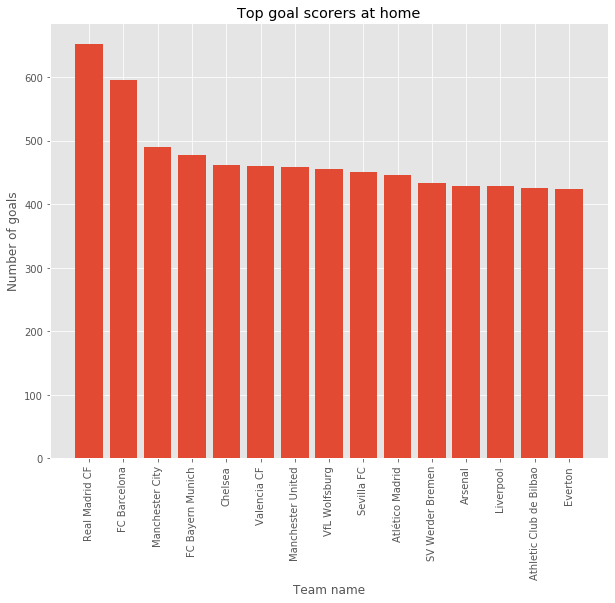

In [15]:
top_goal_scorers_home = matches_h_teams.groupby('home_team_long_name').total_goals.sum().sort_values(ascending = False)
top_goal_scorers_home.head(15)
%matplotlib inline 
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(15), top_goal_scorers_home.head(15).values,align = "center")
ax.set_xticks(range(15))
ax.set_xticklabels(top_goal_scorers_home.head(15).index,rotation = "vertical")
ax.set_title("Top goal scorers at home")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")

Top Goal Scoring Team at away

To see which team scores the most in away matches.

In [16]:
#Merging Away team and matches

matches_a_teams = pd.merge(new_matches,teams,left_on='away_team_api_id', right_on='team_api_id')
matches_a_teams = matches_a_teams.drop(['id','team_api_id','team_fifa_api_id'],axis = 1)
matches_a_teams = matches_a_teams.rename(columns={'team_long_name':'away_team_long_name','name_y':'league_name','name':'country_name'})
matches_a_teams.head()


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,country_name,league_name,away_team_long_name,team_short_name
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League,Newcastle United,NEW
1,1729,9879,10261,2,1,2008/2009,3,1,England,England Premier League,Newcastle United,NEW
2,1729,8455,10261,0,0,2008/2009,0,0,England,England Premier League,Newcastle United,NEW
3,1729,8549,10261,0,0,2008/2009,0,0,England,England Premier League,Newcastle United,NEW
4,1729,8462,10261,0,3,2008/2009,3,-1,England,England Premier League,Newcastle United,NEW


Text(0.5, 0, 'Team name')

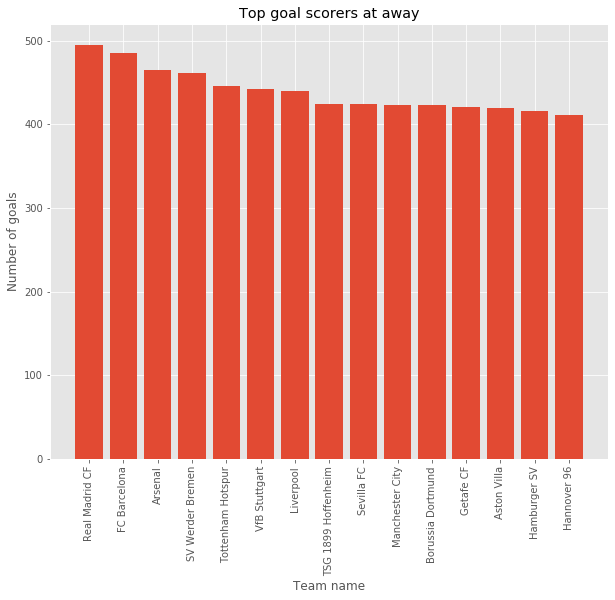

In [17]:
top_goal_scorers_away = matches_a_teams.groupby('away_team_long_name').total_goals.sum().sort_values(ascending = False)
top_goal_scorers_away.head(15)
%matplotlib inline 
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(15), top_goal_scorers_away.head(15).values,align = "center")
ax.set_xticks(range(15))
ax.set_xticklabels(top_goal_scorers_away.head(15).index,rotation = "vertical")
ax.set_title("Top goal scorers at away")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")

In [18]:
#select fields
matches = matches3[matches3.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33


Probability of winning from Betting odds
"Betting Odds"

Calculating entropy to determine predictability

Entropy is calculated to measure the disorder using bet365 odds. The higher the entropy value the more unpredictable are the resuts of the matches.

In [19]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

#compute match entropy
matches['entropy'] = matches.apply(match_entropy,axis=1)

In [20]:
#compute mean entropy for every league in every season
entropy_means = matches.groupby(('season','league_id')).entropy.mean()
entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')
entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]
entropy_means.head(10)

/home/saket/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


,England,Germany,Spain
season,,,
2008/2009,0.984556,1.004276,1.010859
2009/2010,0.956496,0.997925,0.977810
2010/2011,0.983258,1.016264,0.975032
2011/2012,0.969593,1.001298,0.955339
2012/2013,0.981472,0.993993,0.970580
2013/2014,0.960473,0.977500,0.944218
2014/2015,0.980301,0.985835,0.933637
2015/2016,0.997819,0.974657,0.946813


Text(7.3, 0.952, 'more predictable')

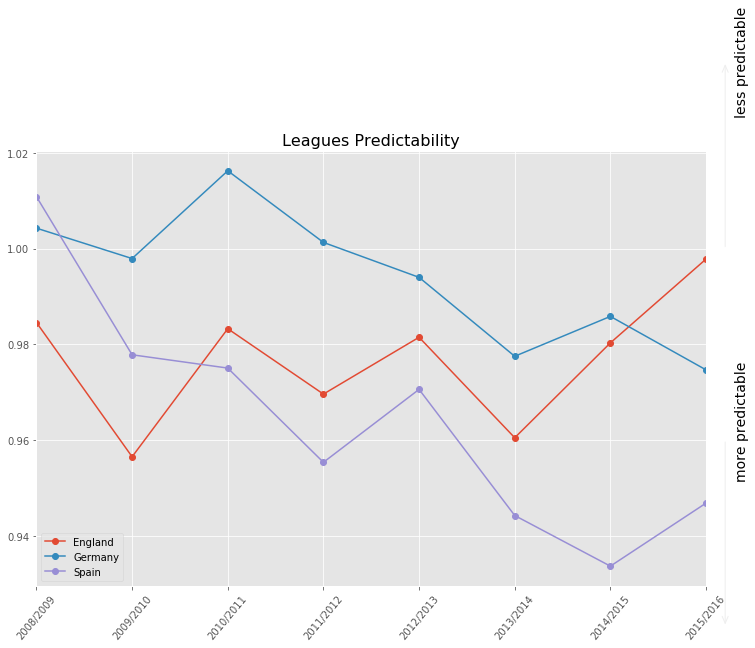

In [21]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

#remove x label
ax.set_xlabel('')

#locate legend 
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

#plt.savefig('figures/leagues_pred.png', bbox_inches='tight',dpi=600)

Since 2008 Bayern Munich and Barcelona have won Bundesliga and La Liga 6 times each.

The top three teams in La Liga are same since 2012. The competition for title race is always between Barcelona, Real Madrid and Athletico Madrid, where Real Madrid won twice and Athletico won once since 2008.

From 2012-13 season Bayern Munich has won Bundesliga 5 times in a row. Borussia Dortmund also performs well and have won the league twice in 09-10 and 10-11 seasons.

Since 2008-09 in Premier League Manchester United have won the league thrice(08-09,10-11,12-13), Manchester City has won twice(11-12,13-14), Chelsea has won thrice(09-10,14-15,16-17) and Leceister City once(15-16). Leceister City was promoted to premier league in the previous season and it was placed 14th at the end of the season. Still it won the league the very next season, so we can see that it is very difficult to predict Premier League.

The English Premier League is more unpredicatable than the rest of the leagues. So we will try to predict the matches for these leagues.

In [22]:
# Considering English Premier League

main_countries = ['England']
countries = countries[countries.name.isin(main_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
seasons = matches.season.unique()
leagues

,id,name,name_y,country_id,name_y
0,1729,England,England,1729,England Premier League


In [23]:
#Merge the leagues with corresponding matches

req_matches = matches2[matches2.league_id.isin(leagues['id'])]
req_matches = req_matches[['id','league_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','season']]
req_matches["total_goals"] = req_matches['home_team_goal'] + req_matches['away_team_goal']
req_matches["result"] = req_matches.apply(res,axis = 1)
req_matches.dropna(inplace=True)
req_matches.tail()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result
4763,4764,1729,8466,8197,2,2,2015/2016,4,0
4764,4765,1729,10003,10194,0,1,2015/2016,1,-1
4765,4766,1729,8586,8650,0,0,2015/2016,0,0
4766,4767,1729,9817,9825,0,3,2015/2016,3,-1
4767,4768,1729,8659,8472,1,0,2015/2016,1,1


In [24]:
new_matches = pd.merge(req_matches,leagues,left_on='league_id', right_on='id')
new_matches = new_matches.drop(['id_x','id_y','country_id'],axis = 1)
english = new_matches[new_matches.name == "England"]

# sum_goals = new_group_matches.home_team_goal.sum()
e = english.groupby('season')
seasons
%matplotlib inline


Home advantages always played important part in match outcome. But by what factor does home advantage affects the match.

Getting total number of goals scored in Home matches

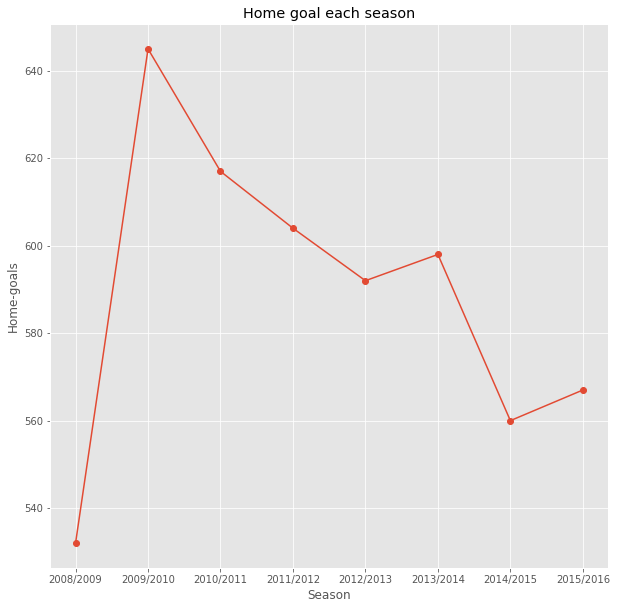

In [25]:
#Plotting home scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home goal each season')
plt.xlabel('Season')
plt.ylabel('Home-goals')
plt.plot(num_seasons,e.home_team_goal.sum().values,label = "English Premier League", marker = 'o')


Total number of goals scored in Away matches

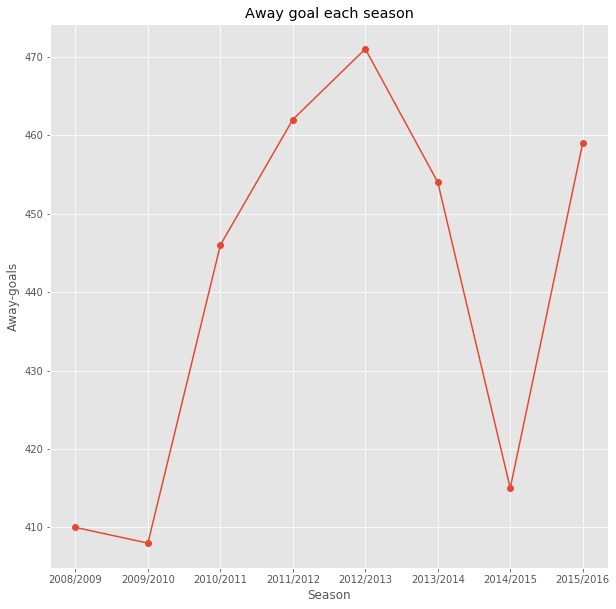

In [26]:
#Plotting away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Away goal each season')
plt.xlabel('Season')
plt.ylabel('Away-goals')
plt.plot(num_seasons,e.away_team_goal.sum().values,label = "English Premier League", marker = 'o')


Home goals to Away goals ratio

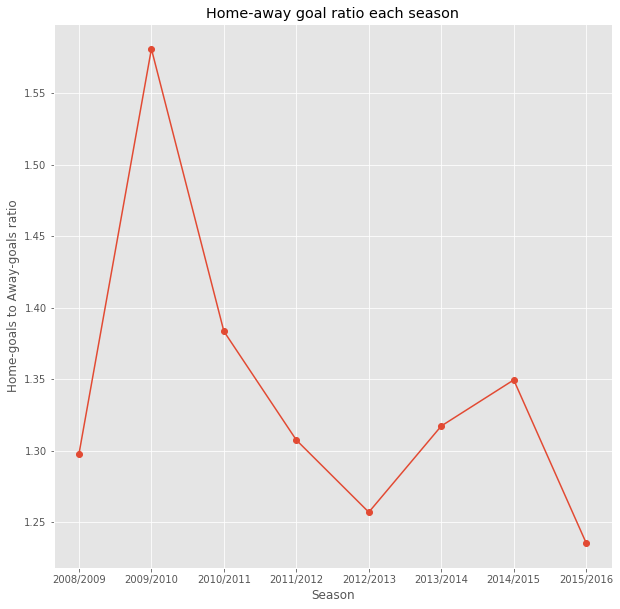

In [27]:
#Plotting home/away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home-away goal ratio each season')
plt.xlabel('Season')
plt.ylabel('Home-goals to Away-goals ratio')
plt.plot(num_seasons,e.home_team_goal.sum().values / e.away_team_goal.sum().values,label = "English Premier League", marker = 'o')


### Home wins vs Home Loss

array([1.57272727, 2.12087912, 1.98888889, 1.47413793, 1.56603774,
       1.45528455, 1.49565217, 1.35344828])

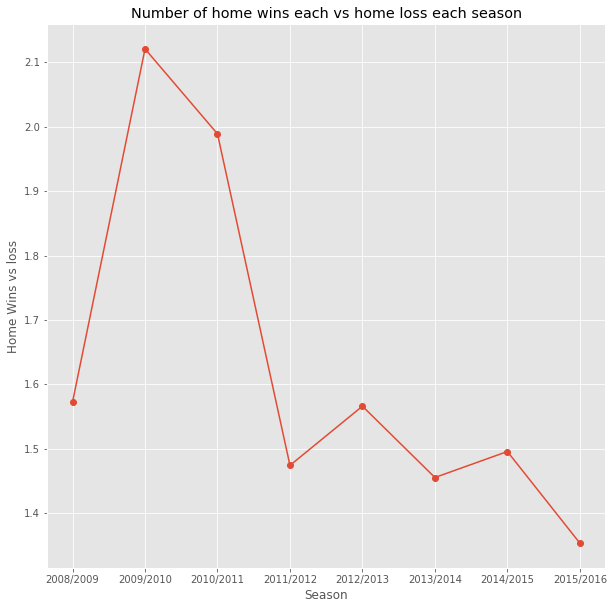

In [28]:
#Subsetting homewins vs homeloss from each of the leagues - ignoring draws.
e_hw = np.true_divide(english[english.result == 1].groupby('season').result.sum().values,english[english.result == -1].groupby('season').result.sum().values * -1)


#Plotting number of home wins vs home losses each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlim = (-20,20)
plt.ylim = (0,120)
plt.title("Number of home wins each vs home loss each season")
plt.xlabel("Season")
plt.ylabel("Home Wins vs loss")
plt.plot(num_seasons,e_hw,label = "English Premier League", marker = 'o')
display(e_hw)